In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [ ]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # weights of pretrained neurons
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

}

In [ ]:
#define data directory
data_dir = '/content/drive/MyDrive/Tumor_Detection'

# Define dataset paths
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Load the datasets using ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

In [ ]:
from torch.utils.data import DataLoader

# Define data loaders for training and validation
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=4, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=4, shuffle=False)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 5722, 'val': 1311}


['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except final classification layer
for name, param in model.named_parameters():
  if "fc" in name: #Unfreeze the final classification layer
    param.requires_grad = True
  else:
    param.requires_grad = False

#Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #Use all parameters

#Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [ ]:
# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set the model to training mode
        else:
            model.eval()   # Set the model to evaluation mode

        running_loss = 0.0
        running_corrects = 0

        # Loop through batches in the current phase
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Reset the gradients

            # Forward pass, and only compute gradients during training
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)  # Get the predicted class labels
                loss = criterion(outputs, labels)  # Calculate the loss

                if phase == 'train':
                    loss.backward()  # Backpropagate the gradients during training
                    optimizer.step()  # Update the model parameters

            running_loss += loss.item() * inputs.size(0)  # Accumulate the loss for the epoch
            running_corrects += torch.sum(preds == labels.data)  # Accumulate correct predictions

        # Calculate epoch-level loss and accuracy after the batch loop
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        # Print the loss and accuracy for the current epoch and phase
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")


train Loss: 1.1152 Acc: 0.6029
val Loss: 0.9570 Acc: 0.7399
train Loss: 0.8681 Acc: 0.6760
val Loss: 0.6064 Acc: 0.7872
train Loss: 0.8467 Acc: 0.6975
val Loss: 0.6199 Acc: 0.8002
train Loss: 0.8364 Acc: 0.6935
val Loss: 0.6290 Acc: 0.7925
train Loss: 0.8241 Acc: 0.6991
val Loss: 0.5016 Acc: 0.8116
train Loss: 0.8112 Acc: 0.7066
val Loss: 0.6055 Acc: 0.8131
train Loss: 0.8246 Acc: 0.7039
val Loss: 0.6531 Acc: 0.7979
train Loss: 0.8252 Acc: 0.6998
val Loss: 0.4800 Acc: 0.8200
train Loss: 0.8192 Acc: 0.7017
val Loss: 0.7126 Acc: 0.7597
train Loss: 0.8142 Acc: 0.7052
val Loss: 0.4852 Acc: 0.8215
Training complete!


In [ ]:
#save model
torch.save(model.state_dict(), 'resnet18_tumor_detection.pth')

In [ ]:

import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn

# Load saved model
from torchvision.models import ResNet18_Weights
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Modify the fully connected layer
model.fc = nn.Linear(model.fc.in_features, 1000)

# Load the state dict (weights) for custom-trained model
model.load_state_dict(torch.load('resnet18_tumor_detection.pth', map_location=torch.device('cpu')))  # Ensure it loads correctly (on CPU or GPU)

# Set model to evaluation mode
model.eval()

# New model with correct final layer for your tumor classification (4 classes)
new_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
new_model.fc = nn.Linear(new_model.fc.in_features, 4)

# Transfer learned weights for the final layer from the saved model
new_model.fc.weight.data = model.fc.weight.data[0:4]
new_model.fc.bias.data = model.fc.bias.data[0:4]


<ipython-input-72-8d0f6799d77f>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18_tumor_detection.pth'))


In [ ]:
import random
# Specify the directory where your test images are stored
test_dataset_dir = '/content/drive/MyDrive/Tumor_Detection/val/notumor'  # Replace with your test dataset directory

# List all image files in the directory (assuming images have .jpg or .png extensions)
image_files = [f for f in os.listdir(test_dataset_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select an image file
random_image_path = os.path.join(test_dataset_dir, random.choice(image_files))

# Load the random image
image = Image.open(random_image_path)

# Convert to RGB if the image is grayscale
if image.mode != 'RGB':
    image = image.convert('RGB')

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# Now input_batch is ready for inference

In [ ]:
#perform inference
with torch.no_grad():
  output = model(input_batch)

#Get predicted class
_, predicted_class = output.max(1)

#Map predicted class to class name
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: no tumor


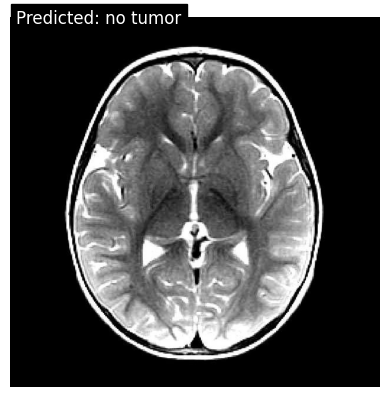

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10,10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='black')
plt.show()